In [ ]:
!pip install tweepy==4.0.0
!pip install pycountry
!pip install BeautifulSoup4
!pip install nltk
!pip install newspaper3k
!pip install newsapi-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60 kB 3.3 MB/s 
  Attempting uninstall: tweepy
    Found existing installation: tweepy 3.10.0
    Uninstalling tweepy-3.10.0:
      Successfully uninstalled tweepy-3.10.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.1 MB 5.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681845 sha256=6eb870ffcebf707f79b9049a0a006cf12b93e352916255aed4e3aea92fa8f444
  Stored in directory: /root/.cache/pip/wheels/0e/06/e8/7ee176e95ea9a8a8c3b3afcb1869f20adbd42413d4611c6eb4
Successfully built pycountry
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking 

In [ ]:
import tweepy
import pandas as pd
import configparser
import re
import matplotlib.pyplot as plt
from textblob import TextBlob
from wordcloud import WordCloud
from geopy.geocoders import Nominatim
import datetime, pytz
import time
import pycountry
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud
from nltk.corpus import wordnet as wn
import nltk
from nltk.corpus import wordnet as wn
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
import string

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [ ]:
def twitter_connection():

    config = configparser.ConfigParser()
    config.read("config.ini")

    api_key = config["twitter"]["api_key"]
    api_key_secret = config["twitter"]["api_key_secret"]
    access_token = config["twitter"]["access_token"]

    auth = tweepy.OAuthHandler(api_key, api_key_secret)
    api = tweepy.API(auth)

    return api
api = twitter_connection()

KeyError: ignored

In [ ]:
def cleanTxt(text):
    text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
    text = re.sub('#', '', text) # Removing '#' hash tag
    text = re.sub('RT[\s]+', '', text) # Removing RT
    text = re.sub('https?:\/\/\S+', '', text)
    text = re.sub("\n","",text) # Removing hyperlink
    text = re.sub(":","",text) # Removing hyperlink
    text = re.sub("_","",text) # Removing hyperlink
    text = emoji_pattern.sub(r'', text)
    return text

def stopword_removal_tweet(text):
    sw=stopwords.words('english')
    # user defined stopwords is added to the NLTK stopwords based on real-time Twitter tweets.
    sw.extend(['the','va','wa','ha','i','we','ve','le','u','hi','...',"i've","i'm","we've",'im','):','w','ian'])
    words = [word for word in text.split(" ") if word.lower() not in sw]
    words = list(filter(len,words))
    #print("Text Tweets after removing stopwords:", words)
    return words

def generate_N_grams(Wordlist,ngram):
  temp=zip(*[Wordlist[i:] for i in range(0,ngram)])
  result=[' '.join(ngram) for ngram in temp]
  return result

def lemmatize_text(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    w_tokenizer = TweetTokenizer()
    return [(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize(text)]

def remove_punctuation(text):
    exceptional=['...','..']
    if(type(text)==float):
        return text
    preprocessed=""
    preprocessed_result = " ".join(text)
    for elt in text:
        if elt not in string.punctuation and exceptional:
            preprocessed=preprocessed+' '+elt
            preprocessed_result= preprocessed.replace('...','')
    return preprocessed_result.lower().replace(':/','')

In [ ]:
def extract_mentions(text):
    text = re.findall("(@[A-Za-z0–9\d\w]+)", text)
    return text

def extract_hastag(text):
    text = re.findall("(#[A-Za-z0–9\d\w]+)", text)
    return text

def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity

def getAnalysis(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'

In [ ]:
def preprocessing_data(word_query, number_of_tweets, function_option):

  if function_option == "Search By #Tag and Words":
    posts = tweepy.Cursor(api.search_tweets, q=word_query+" -filter:retweets", count = 200, lang ="en", tweet_mode="extended").items((number_of_tweets))

  if function_option == "Search By Username":
    posts = tweepy.Cursor(api.user_timeline, screen_name=word_query, count = 200, tweet_mode="extended").items((number_of_tweets))

  # store the API responses in a list
  tweets_copy = []
  for tweet in posts:
      tweets_copy.append(tweet)
  print(len(tweets_copy))
  data  = pd.DataFrame()
  # data  = pd.DataFrame([tweet.full_text for tweet in posts], columns=['Tweets'])
  for tweet in tweets_copy:
    hashtags = []
    # text = ""
    try:
        for hashtag in tweet.entities["hashtags"]:
            hashtags.append(hashtag["text"])
    except:
        pass
    text = api.get_status(id=tweet.id, tweet_mode='extended').full_text
    data = data.append(pd.DataFrame({'user_name': tweet.user.name,
                                               'user_location': tweet.user.location,\
                                               'user_description': tweet.user.description,
                                               'followers_count' : tweet.user.followers_count,
                                               'retweet_count' : tweet.retweet_count,
                                               'favorite_count' : tweet.favorite_count,
                                               'user_verified': tweet.user.verified,
                                               'date': tweet.created_at,
                                               'Tweets': text,
                                               'hashtags': [hashtags if hashtags else None]
                                               }))

  data["mentions"] = data["Tweets"].apply(extract_mentions)
  data["hastags"] = data["Tweets"].apply(extract_hastag)
  data['links'] = data['Tweets'].str.extract('(https?:\/\/\S+)', expand=False).str.strip()
  data['retweets'] = data['Tweets'].str.extract('(RT[\s@[A-Za-z0–9\d\w]+)', expand=False).str.strip()

  data['Tweets'] = data['Tweets'].apply(cleanTxt)
  discard = ["CNFTGiveaway", "GIVEAWAYPrizes", "Giveaway", "Airdrop", "GIVEAWAY", "makemoneyonline", "affiliatemarketing"]
  data = data[~data["Tweets"].str.contains('|'.join(discard))]

  data['Subjectivity'] = data['Tweets'].apply(getSubjectivity)
  data['Polarity'] = data['Tweets'].apply(getPolarity)

  data['Analysis'] = data['Polarity'].apply(getAnalysis)

  return data

In [ ]:
def analyse_mention(data):

  mention = pd.DataFrame(data["mentions"].to_list()).add_prefix("mention_")

  try:
    mention = pd.concat([mention["mention_0"], mention["mention_1"], mention["mention_2"]], ignore_index=True)
  except:
    mention = pd.concat([mention["mention_0"]], ignore_index=True)

  mention = mention.value_counts().head(10)

  return mention



def analyse_hastag(data):

  hastag = pd.DataFrame(data["hastags"].to_list()).add_prefix("hastag_")

  try:
    hastag = pd.concat([hastag["hastag_0"], hastag["hastag_1"], hastag["hastag_2"]], ignore_index=True)
  except:
    hastag = pd.concat([hastag["hastag_0"]], ignore_index=True)

  hastag = hastag.value_counts().head(10)

  return hastag


def analyse_link(data):
  link = pd.DataFrame(data["links"].to_list()).add_prefix("link_")

  try:
    link = pd.concat([link["link_0"], link["link_1"], link["link_2"]], ignore_index=True)
  except:
    link = pd.concat([link["link_0"]], ignore_index=True)

  link = link.value_counts().head(10)

  return link


def graph_sentiment(data):

  analys = data["Analysis"].value_counts().reset_index().sort_values(by="index", ascending=False)

  return analys

In [ ]:
word_query = "sufjan"
number_of_tweets = 100
function_option = "Search By #Tag and Words"

In [ ]:
data= preprocessing_data(word_query, number_of_tweets, function_option)
data.shape

In [ ]:
data.drop_duplicates(subset = "Tweets", inplace = True, keep= False)
print(data.shape)
data.head()

(835, 17)


,user_name,user_location,user_description,followers_count,retweet_count,favorite_count,user_verified,date,Tweets,hashtags,mentions,hastags,links,retweets,Subjectivity,Polarity,Analysis
0,Hello: My Name is....,NorCal,I'm merely using this as a tool to further exp...,88,0,0,False,2022-07-26 04:18:51+00:00,630 This is just incorrect. Krystal Ball is ...,None,"[@jacobrossitx, @auroraalex630, @Acyn]",[],NaN,NaN,0.637500,-0.012500,Negative
0,Tweets,,,2,0,0,False,2022-07-26 04:18:50+00:00,Yeah I'm thinking our country has provided en...,None,[@TMZ],[],NaN,NaN,0.500000,0.000000,Neutral
0,#stopchildabuse,USA,"If You Care Enough, You Can Change The World. ...",45127,0,0,False,2022-07-26 04:18:49+00:00,The latest The helpspreadthis Daily! Thanks t...,"[ukraine, foreverychild]",[@IWFhotline],"[#ukraine, #foreverychild]",https://t.co/0O4SzKDUIk,NaN,0.366667,0.233333,Positive
0,Zaks Ruksaks,"Washington, DC",Even if I hate your opinion or completely disa...,12,0,0,False,2022-07-26 04:18:48+00:00,DoginAL Ukraine has been preparing for 5 mon...,None,"[@Red_Dog_in_AL, @ClareAdams, @WarintheFuture]",[],NaN,NaN,0.504630,0.233333,Positive
0,WannabePhotographer41,,"Utah Educator. LDS. Love history, photography,...",774,0,0,False,2022-07-26 04:18:40+00:00,Trump was calling putin a genius for invading...,None,[@svdate],[],https://t.co/4nE5CnkP2w,NaN,0.100000,-0.200000,Negative


In [ ]:
countryname = []
location = data['user_location'].tolist()
start = time.time()
for i in range(len(location)):
  flag = False
  if str(location[i]) != 'nan':
    country_list = []
    for country in pycountry.countries:
        location[i] = re.sub("UK","GB",location[i])
        if country.name in location[i] or country.alpha_2 in location[i] or country.alpha_3 in location[i]:
          country_list.append(country.name)
    if country_list:
        if len(country_list) > 1:
          country_list.sort(key=len)
          countryname.append(country_list[-1])
        else:
          countryname.append(country_list[0])
    else:
        countryname.append("Unknown")

data['country'] = countryname

In [ ]:
# Removing Numbers - cleaning stage.
data['Numbers_Removed_Text']=data['Tweets'].str.replace('\d+', '')
data['Text_lemmatize']= data['Numbers_Removed_Text'].apply(lemmatize_text)
# punctuation removal.
data['PreProcessed_Tweet_text']=data['Text_lemmatize'].apply(lambda x:remove_punctuation(x))
# Stopword Removal
data['StopWords_Removed']=data['PreProcessed_Tweet_text'].apply(stopword_removal_tweet)
data['PreProcessed_Tweet_text']=data['StopWords_Removed'].apply(lambda x: " ".join(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
#Getting list of all sentences
sentences = []
for row in data['Tweets']:
  split_sentences = nltk.sent_tokenize(row)
  sentences.extend(split_sentences)
print(len(sentences))
print(sentences)

1638
[' 630  This is just incorrect.', 'Krystal Ball is pretty moderate with a progressive lean.', "Just because someone is critical of Ukraine doesn't mean they are a Russian shill.", 'Way to generalize.', " Yeah I'm thinking our country has provided enough cash to Ukraine- I'd hold onto that ring", 'The latest The helpspreadthis Daily!', 'Thanks to  ukraine foreverychild', 'DoginAL   Ukraine has been preparing for 5 months.', 'Nevermind the attrition rates of trained troops and officers, sure they are ready for brigade / division ops with some guys who just finished a basic course.', ' Trump was calling putin a genius for invading Ukraine a few months ago.', 'I’m not a conservative, but what these guys are saying is true.', 'Biden has helped turn Ukraine into a ruthless, lawless, oppressive autocracy.', 'Our ongoing policy to support Zelensky is completely screwed up.', 'First Ukraine grain ships may move in days, says U.N.  UN First Ukraine GrainShip', 'Returned after 12 h ban, twit

In [ ]:
data.to_csv('twitter.csv')

In [ ]:
data = pd.read_csv('twitter.csv')
data.head(10)

In [ ]:
data.dtypes

user_name                               object
user_location                           object
user_description                        object
followers_count                          int64
retweet_count                            int64
favorite_count                           int64
user_verified                             bool
date                       datetime64[ns, UTC]
Tweets                                  object
hashtags                                object
mentions                                object
hastags                                 object
links                                   object
retweets                                object
Subjectivity                           float64
Polarity                               float64
Analysis                                object
country                                 object
Numbers_Removed_Text                    object
Text_lemmatize                          object
PreProcessed_Tweet_text                 object
StopWords_Rem

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 835 entries, 0 to 0
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   user_name                835 non-null    object             
 1   user_location            835 non-null    object             
 2   user_description         835 non-null    object             
 3   followers_count          835 non-null    int64              
 4   retweet_count            835 non-null    int64              
 5   favorite_count           835 non-null    int64              
 6   user_verified            835 non-null    bool               
 7   date                     835 non-null    datetime64[ns, UTC]
 8   Tweets                   835 non-null    object             
 9   hashtags                 149 non-null    object             
 10  mentions                 835 non-null    object             
 11  hastags                  835 non-n

In [ ]:
data.describe()

,followers_count,retweet_count,favorite_count,Subjectivity,Polarity
count,8.350000e+02,835.000000,835.000000,835.000000,835.000000
mean,5.218949e+04,0.283832,1.257485,0.331319,0.073258
std,7.934711e+05,2.059584,7.728737,0.289552,0.240849
min,0.000000e+00,0.000000,0.000000,0.000000,-1.000000
25%,3.650000e+01,0.000000,0.000000,0.000000,0.000000
50%,2.390000e+02,0.000000,0.000000,0.333333,0.000000
75%,1.660500e+03,0.000000,1.000000,0.525000,0.167468
max,2.218183e+07,32.000000,120.000000,1.000000,1.000000


In [ ]:
data.head()

,user_name,user_location,user_description,followers_count,retweet_count,favorite_count,user_verified,date,Tweets,hashtags,...,links,retweets,Subjectivity,Polarity,Analysis,country,Numbers_Removed_Text,Text_lemmatize,PreProcessed_Tweet_text,StopWords_Removed
0,Hello: My Name is....,NorCal,I'm merely using this as a tool to further exp...,88,0,0,False,2022-07-26 04:18:51+00:00,630 This is just incorrect. Krystal Ball is ...,None,...,NaN,NaN,0.637500,-0.012500,Negative,Unknown,This is just incorrect. Krystal Ball is pre...,"[This, is, just, incorrect, ., Krystal, Ball, ...",incorrect krystal ball pretty moderate progres...,"[incorrect, krystal, ball, pretty, moderate, p..."
0,Tweets,,,2,0,0,False,2022-07-26 04:18:50+00:00,Yeah I'm thinking our country has provided en...,None,...,NaN,NaN,0.500000,0.000000,Neutral,Unknown,Yeah I'm thinking our country has provided en...,"[Yeah, I'm, thinking, our, country, ha, provid...",yeah thinking country provided enough cash ukr...,"[yeah, thinking, country, provided, enough, ca..."
0,#stopchildabuse,USA,"If You Care Enough, You Can Change The World. ...",45127,0,0,False,2022-07-26 04:18:49+00:00,The latest The helpspreadthis Daily! Thanks t...,"[ukraine, foreverychild]",...,https://t.co/0O4SzKDUIk,NaN,0.366667,0.233333,Positive,United States,The latest The helpspreadthis Daily! Thanks t...,"[The, latest, The, helpspreadthis, Daily, !, T...",latest helpspreadthis daily thanks ukraine for...,"[latest, helpspreadthis, daily, thanks, ukrain..."
0,Zaks Ruksaks,"Washington, DC",Even if I hate your opinion or completely disa...,12,0,0,False,2022-07-26 04:18:48+00:00,DoginAL Ukraine has been preparing for 5 mon...,None,...,NaN,NaN,0.504630,0.233333,Positive,Unknown,DoginAL Ukraine has been preparing for mont...,"[DoginAL, Ukraine, ha, been, preparing, for, m...",doginal ukraine preparing month nevermind attr...,"[doginal, ukraine, preparing, month, nevermind..."
0,WannabePhotographer41,,"Utah Educator. LDS. Love history, photography,...",774,0,0,False,2022-07-26 04:18:40+00:00,Trump was calling putin a genius for invading...,None,...,https://t.co/4nE5CnkP2w,NaN,0.100000,-0.200000,Negative,Unknown,Trump was calling putin a genius for invading...,"[Trump, wa, calling, putin, a, genius, for, in...",trump calling putin genius invading ukraine mo...,"[trump, calling, putin, genius, invading, ukra..."


In [ ]:
analyse = graph_sentiment(data)
mention = analyse_mention(data)
hastag = analyse_hastag(data)
links = analyse_link(data)

In [ ]:
analyse

,index,Analysis
0,Positive,373
1,Neutral,283
2,Negative,179


In [ ]:
mention

@YouTube            16
@POTUS              12
@ggreenwald         10
@KyivIndependent    10
@stillgray           7
@AdamKinzinger       6
@blackintheempir     5
@Acyn                5
@Reuters             5
@TulsiGabbard        5
dtype: int64

In [ ]:
hastag

#Ukraine             67
#Russia              14
#Russian              8
#UkraineWar           6
#russia               6
#UkraineRussiaWar     5
#news                 5
#StandWithUkraine     3
#ibmtv                3
#293                  3
dtype: int64

In [ ]:
links

https://t.co/LdesxWob67    2
https://t.co/CJ0P2S9IAD    2
https://t.co/dBqIKI7rh9    2
https://t.co/0O4SzKDUIk    1
https://t.co/5DvFV9zpq0    1
https://t.co/wwHRpcGTX2    1
https://t.co/cDcDr30E0f    1
https://t.co/q3ztME3lxO    1
https://t.co/QLG6OpOXxF    1
https://t.co/PKEFHNWZiM    1
Name: link_0, dtype: int64

Knowledge Graph try out


In [ ]:
import spacy
import pandas as pd
import requests
from spacy import displacy

nlp = spacy.load('en_core_web_sm')

from spacy.tokens import Span
from spacy.matcher import Matcher

import matplotlib.pyplot as plot
from tqdm import tqdm
import networkx as ntx
%matplotlib inline

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [ ]:
# Get all entities and their tags
chunks = {}
for sent in sentences:
  for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
     if hasattr(chunk, 'label'):
        if chunk.label() not in chunks:
          chunks[chunk.label()] = []
        chunks[chunk.label()].append(" ".join(c[0] for c in chunk))

In [ ]:
from collections import Counter

entity_count = Counter(chunks['PERSON'])
entity_count.most_common()
print(chunks.keys())
print(entity_count.most_common())


dict_keys(['PERSON', 'ORGANIZATION', 'GPE', 'GSP', 'LOCATION', 'FACILITY'])
[('Ukraine', 83), ('Putin', 49), ('Zelensky', 12), ('Biden', 11), ('Trump', 10), ('Nord Stream', 8), ('Odesa', 5), ('Kyiv', 4), ('Kherson', 4), ('Brexit', 3), ('Volodymyr Zelensky', 3), ('Sergei Lavrov', 3), ('Glenn Greenwald', 3), ('Annual Black Sea Drills', 3), ('Citing Ukraine War', 3), ('Andy', 3), ('Moldova', 3), ('Obama', 3), ('Nazis', 3), ('Zelenskyy', 3), ('Andriod One App', 3), ('Tulsi Gabbard', 2), ('Myanmar', 2), ('Nightlife Comes Back Amid Urge', 2), ('Orban', 2), ('Vermaut', 2), ('Georgia', 2), ('Covid Vaccine', 2), ('Canada Ukraine Russia', 2), ('Thread Russian', 2), ('Young', 2), ('Black Sea', 2), ('Vageta', 2), ('Arab', 2), ('Donbas', 2), ('Crimea', 2), ('Volodymyr Zelenskyy', 2), ('Peace', 2), ('Zelensky Ukraine', 2), ('Pinker', 2), ('Movie BB Breaking', 2), ('Ukraine WW3 Putin Sweden', 2), ('Did', 2), ('Hunter', 2), ('Joe', 2), ('Adam', 2), ('Joe Biden', 2), ('Oil', 2), ('Kharkiv', 2), ('Ukrai

In [ ]:
verified_mentions = []
for x in mention.index:
    try:
        u = api.get_user(screen_name = x)
        verified_mentions.append(u.name)
    except Exception:
            pass
print(verified_mentions)

['YouTube', 'President Biden', 'Glenn Greenwald', 'The Kyiv Independent', 'Ian Miles Cheong', 'Adam Kinzinger🇺🇦🇺🇸✌️', 'Black in the Empire', 'Acyn', 'Reuters', 'Tulsi Gabbard 🌺']


In [ ]:
entity_dict = {key: [] for key in verified_mentions}


In [ ]:
X = verified_mentions.copy()
for k in chunks.keys():
  X.extend(chunks[k])

In [ ]:
for x in X:
  for key in entity_dict.keys():
    if x in key:
      entity_dict[key].append(x)


In [ ]:
frequencies_dict = { key : {'Frequency' : len(entity_dict[key]), 'Unique_words' : list(set(entity_dict[key])), 'Hashtags' : [] } for key in entity_dict}


user_name
user_location
user_description
followers_count
retweet_count
favorite_count
user_verified
date
Tweets
hashtags
mentions
hastags
links
retweets
Subjectivity
Polarity
Analysis
country
Numbers_Removed_Text
Text_lemmatize
PreProcessed_Tweet_text
StopWords_Removed


Toeknize each sentence, search for entities using frequencies_dict and create pairs of entities

In [ ]:
import re

all_bigrams = bigram_frequency[bigram_frequency> bigram_frequency.quantile(0.99)].index

def extract_entities(sentence):
  entities = []
  for key in frequencies_dict:
    for uw in frequencies_dict[key]['Unique_words']:
      if sentence.lower().find(uw.lower()) >= 0:
        entities.append((key, sentence.lower().find(uw.lower())))


  for bigram in all_bigrams:
    if bigram in sentence.lower():
      entities.append((bigram, sentence.lower().find(bigram.lower())))

  entities.sort(key = lambda x: x[1])


  return [enti[0] for enti in entities][:2]

In [ ]:
pairs_of_entities = []
for i in tqdm(sentences):
   pairs_of_entities.append(extract_entities(i))

100%|██████████| 1638/1638 [00:00<00:00, 16664.49it/s]


In [ ]:
pairs_of_entities

In [ ]:
def obtain_relation(sent):

   doc = nlp(sent)
   matcher = Matcher(nlp.vocab)

   pattern = [[{'DEP':'ROOT'},
           {'DEP':'prep','OP':"?"},
           {'DEP':'agent','OP':"?"},
           {'POS':'ADJ','OP':"?"}]]

  #  matcher.add("matching_1", None, pattern)
   matcher.add('matching_1', pattern)

   matcher = matcher(doc)
   h = len(matcher) - 1
   if h >= 0:
    span = doc[matcher[h][1]:matcher[h][2]]
    return (span.text)
   else:
    return ""
relations = [obtain_relation(j) for j in sentences]

In [ ]:
pd.Series(relations).value_counts()[:50]

In [ ]:
# subject extraction

source = []
#object extraction
for k in pairs_of_entities:
  if len(k) > 1:
    source.append(k[0])
  else:
    source.append("")


target = []
#object extraction
for k in pairs_of_entities:
  if len(k) > 1:
    target.append(k[1])
  else:
    target.append("")

data_kgf = pd.DataFrame({'source':source, 'edge':relations, 'target':target})

In [ ]:
data_kgf.to_csv('graph.csv', index=False)

# Create DG from the dataframe
graph = ntx.from_pandas_edgelist(data_kgf, "source", "target",
                         edge_attr=True, create_using=ntx.MultiDiGraph())

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127802 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127462 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127802 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127482 missing from current font.
  font.

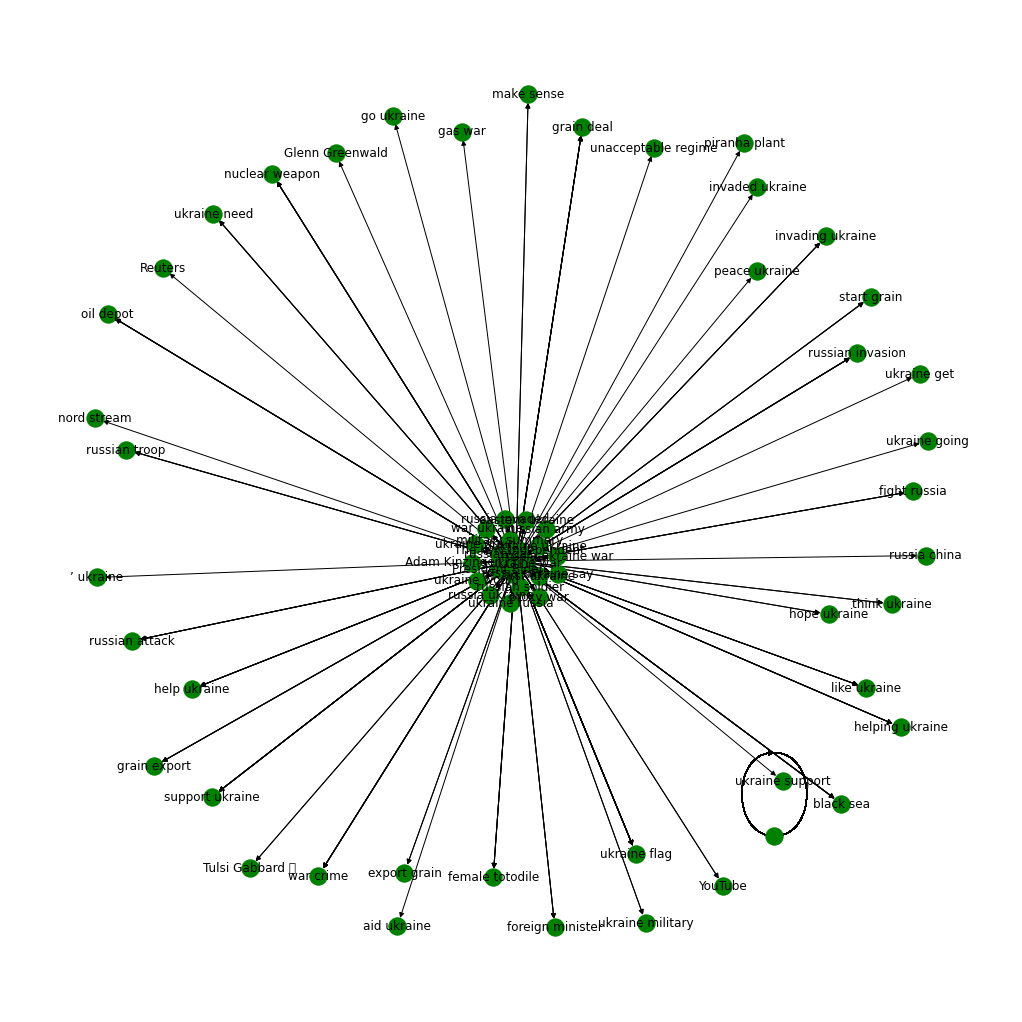

In [ ]:
# plotting the network
plot.figure(figsize=(14, 14))
posn = ntx.spring_layout(graph)
ntx.draw(graph, with_labels=True, node_color='green', edge_cmap=plot.cm.Blues, pos = posn)
plot.show()

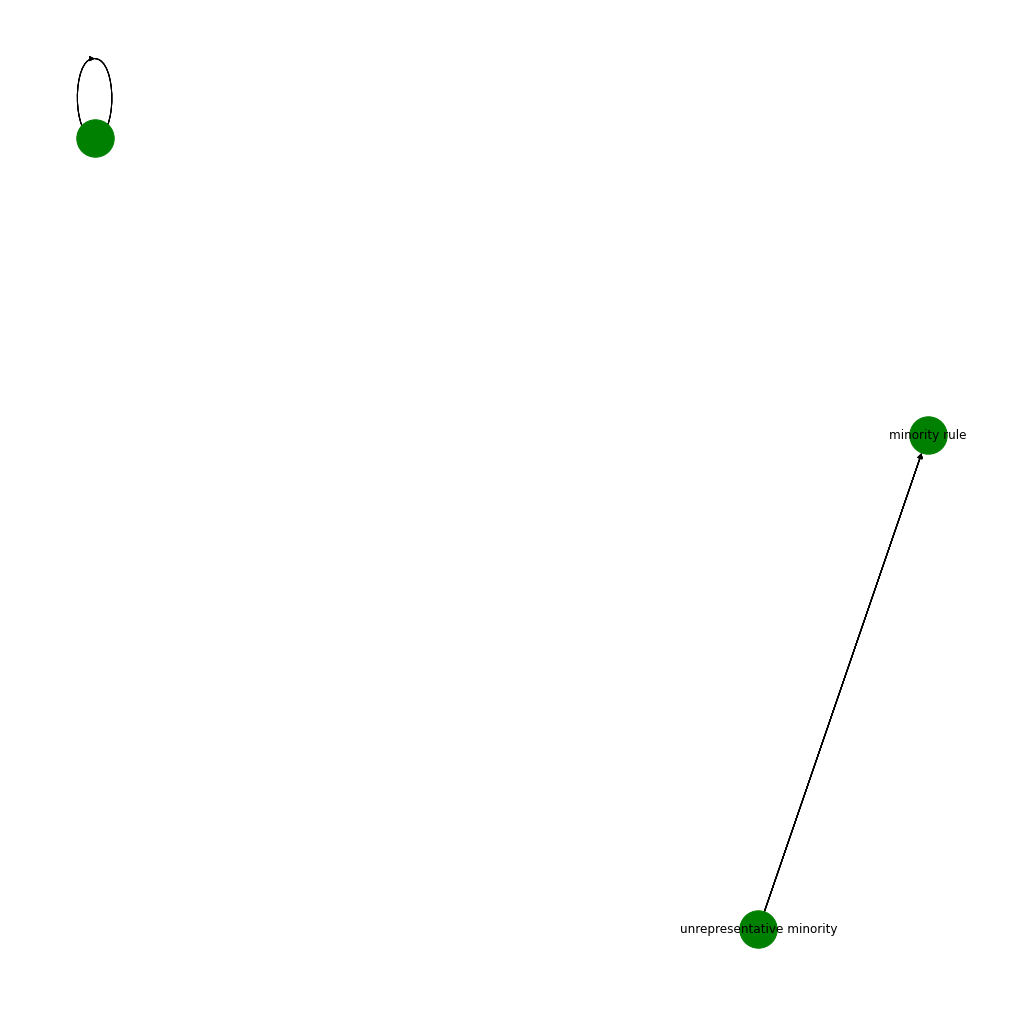

In [ ]:
graph = ntx.from_pandas_edgelist(data_kgf[data_kgf['edge']=="Join"], "source", "target",
                         edge_attr=True, create_using=ntx.MultiDiGraph())

plot.figure(figsize=(14,14))
pos = ntx.spring_layout(graph, k = 0.5) # k regulates the distance between nodes
ntx.draw(graph, with_labels=True, node_color='green', node_size=1400, edge_cmap=plot.cm.Blues, pos = posn)
plot.show()

In [ ]:
all_together = data['StopWords_Removed'].values.tolist()
flat_list = [item for sublist in all_together for item in sublist]
removetable = str.maketrans('','','...')
# making all different tweet message flatten into a single list.
flatten_list =[s.translate(removetable) for s in flat_list]

In [ ]:
# Bigram Detection
print("Processing bigram Detection :)")
bigram_result=generate_N_grams(flatten_list,2)

bigrams = pd.DataFrame(bigram_result, columns = ["Bigram"])
bigram_frequency = bigrams["Bigram"].value_counts().sort_values( ascending=False)
bigram_frequency.head(10)

Processing bigram Detection :)


war ukraine         48
ukraine war         33
russia ukraine      22
ukraine ’           21
ukraine russia      19
grain deal          15
ukraine ukraine     15
ukraine flag        14
invasion ukraine    13
support ukraine     13
Name: Bigram, dtype: int64

In [ ]:
# Trigram Detection
print("Processing Trigram Detection :)")
trigram=generate_N_grams(flatten_list,3)
print(trigram)

trigrams = pd.DataFrame(trigram, columns = ["Trigram"])
trigram_frequency = trigrams["Trigram"].value_counts().reset_index().sort_values(by="Trigram", ascending=False)
trigram_frequency.head(10)

Processing Trigram Detection :)
['incorrect krystal ball', 'krystal ball pretty', 'ball pretty moderate', 'pretty moderate progressive', 'moderate progressive lean', 'progressive lean someone', 'lean someone critical', 'someone critical ukraine', 'critical ukraine mean', 'ukraine mean russian', 'mean russian shill', 'russian shill way', 'shill way generalize', 'way generalize yeah', 'generalize yeah thinking', 'yeah thinking country', 'thinking country provided', 'country provided enough', 'provided enough cash', 'enough cash ukraine', "cash ukraine i'd", "ukraine i'd hold", "i'd hold onto", 'hold onto ring', 'onto ring latest', 'ring latest helpspreadthis', 'latest helpspreadthis daily', 'helpspreadthis daily thanks', 'daily thanks ukraine', 'thanks ukraine foreverychild', 'ukraine foreverychild doginal', 'foreverychild doginal ukraine', 'doginal ukraine preparing', 'ukraine preparing month', 'preparing month nevermind', 'month nevermind attrition', 'nevermind attrition rate', 'attrit

,index,Trigram
0,russia waging gas,8
1,waging gas war,8
2,war russia waging,7
4,nord stream cut,7
5,war nord stream,7
6,gas war nord,7
3,stream cut zelensky,7
7,ukraine grain deal,6
8,ukraine war russia,6
25,hope ukraine grain,5


In [ ]:
cleantxt = ' '.join(text for text in data['PreProcessed_Tweet_text'])
wordcloud = WordCloud(background_color='black', random_state=11, max_font_size=100, max_words=150, width=1000,
                      height=1000).generate(cleantxt)
fig = plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Cleaned Text Tweets', loc='center')

In [ ]:
positive_words = ' '.join(
    [text for text in data['PreProcessed_Tweet_text'][data['Analysis'] == "Positive"]])
wordcloud = WordCloud(background_color='green', width=1000, height=1000, random_state=11,
                      max_font_size=110).generate(positive_words)
fig = plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Positive Text Tweets', loc='center')

In [ ]:
negative_words = ' '.join(
    [text for text in data['PreProcessed_Tweet_text'][data['Analysis'] == "Negative"]])
wordcloud = WordCloud(background_color='red', width=1000, height=1000, random_state=11,
                      max_font_size=110).generate(negative_words)
fig = plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Positive Text Tweets', loc='center')

In [ ]:
neutral_words = ' '.join(
    [text for text in data['PreProcessed_Tweet_text'][data['Analysis'] == "Neutral"]])
wordcloud = WordCloud(background_color='orange', width=1000, height=1000, random_state=11,
                      max_font_size=110).generate(neutral_words)
fig = plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Neutral Text Tweets', loc='center')

In [ ]:
country_frequency = data["country"].value_counts().reset_index().sort_values(by="country", ascending=False)
country_frequency

LDA


In [ ]:
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
stop_words = stopwords.words('english')

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]

data_text = data.PreProcessed_Tweet_text.values.tolist()
data_words = list(sent_to_words(data_text))
# remove stop words
data_words = remove_stopwords(data_words)
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_words]

# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

n_topics = 3
# Build LDA model
lda_model = LDA(corpus=corpus, id2word=id2word,
                num_topics= n_topics, random_state=100,
                chunksize=1000, passes=40, iterations=100)

topics = lda_model.show_topics(num_topics= n_topics, formatted=False)
topic_word_list = []

for i in range(n_topics):
    topic_word_list.append(dict(topics[i][1]))

import matplotlib.colors as mcolors

# create wordclouds
# cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# cloud = WordCloud(stopwords=stop_words,
#                   background_color='white',
#                   width=2500,
#                   height=1800,
#                   max_words=1000,
#                   colormap='tab10',
#                   color_func=lambda *args, **kwargs: cols[i],
#                   prefer_horizontal=1.0)

# fig, axes = plt.subplots(1, n_topics, figsize=(20,20), sharex=True, sharey=True)

# for i, ax in enumerate(axes.flatten()):
#     print(i, ax)
#     fig.add_subplot(ax)
#     cloud.generate_from_frequencies(topic_word_list[i])
#     plt.gca().imshow(cloud)
#     plt.gca().axis('off')


# plt.subplots_adjust(wspace=0, hspace=0)
# plt.axis('off')
# plt.margins(x=0, y=0)
# plt.tight_layout()
# plt.show()

In [ ]:
unigrams = []
for topic in topics:
  l = topic[1]
  l.sort(key = lambda x: x[1], reverse = True)
  l = l[: min(len(l)//3, 3)]
  unigrams.extend([x[0] for x in l])
unigrams = list(set(unigrams))
print(unigrams)

['war', 'russia', 'russian', 'ukraine']


In [ ]:
bigram_words = []
for word in data_words:
  bigram_words.append(generate_N_grams(word, 2))

# data_words = list(sent_to_words(data_text))
# # remove stop words
# data_words = remove_stopwords(data_words)
# Create Dictionary
id2word = corpora.Dictionary(bigram_words)
# Create Corpus
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in bigram_words]

# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# n_topics = 5
# Build LDA model
lda_model = LDA(corpus=corpus, id2word=id2word,
                num_topics= n_topics, random_state=100,
                chunksize=1000, passes=40, iterations=100)

topics = lda_model.show_topics(num_topics= n_topics, formatted=False)

topic_word_list = []

for i in range(n_topics):
    topic_word_list.append(dict(topics[i][1]))

import matplotlib.colors as mcolors

# create wordclouds
# cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# cloud = WordCloud(stopwords=stop_words,
#                   background_color='white',
#                   width=2500,
#                   height=1800,
#                   max_words=1000,
#                   colormap='tab10',
#                   color_func=lambda *args, **kwargs: cols[i],
#                   prefer_horizontal=1.0)

# fig, axes = plt.subplots(1, n_topics, figsize=(20,20), sharex=True, sharey=True)

# for i, ax in enumerate(axes.flatten()):
#     print(i, ax)
#     fig.add_subplot(ax)
#     cloud.generate_from_frequencies(topic_word_list[i])
#     plt.gca().imshow(cloud)
#     plt.gca().axis('off')


# plt.subplots_adjust(wspace=0, hspace=0)
# plt.axis('off')
# plt.margins(x=0, y=0)
# plt.tight_layout()
# plt.show()
# topics_list = []

In [ ]:
bigrams = []
for topic in topics:
  l = topic[1]
  l.sort(key = lambda x: x[1], reverse = True)
  l = l[: min(len(l)//3, 3)]
  bigrams.extend([x[0] for x in l])
bigrams = list(set(bigrams))
print(bigrams)

['russia ukraine', 'war ukraine', 'ukraine grain', 'invasion ukraine', 'ukraine war', 'ukraine russia']


In [ ]:
trigram_words = []
for word in data_words:
  trigram_words.append(generate_N_grams(word, 3))

# data_words = list(sent_to_words(data_text))
# # remove stop words
# data_words = remove_stopwords(data_words)
# Create Dictionary
id2word = corpora.Dictionary(trigram_words)
# Create Corpus
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in trigram_words]

# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# n_topics = 5
# Build LDA model
lda_model = LDA(corpus=corpus, id2word=id2word,
                num_topics= n_topics, random_state=100,
                chunksize=1000, passes=40, iterations=100)

topics = lda_model.show_topics(num_topics= n_topics, formatted=False)

topic_word_list = []

for i in range(n_topics):
    topic_word_list.append(dict(topics[i][1]))



# import matplotlib.colors as mcolors

# # create wordclouds
# cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# cloud = WordCloud(stopwords=stop_words,
#                   background_color='white',
#                   width=2500,
#                   height=1800,
#                   max_words=1000,
#                   colormap='tab10',
#                   color_func=lambda *args, **kwargs: cols[i],
#                   prefer_horizontal=1.0)

# fig, axes = plt.subplots(1, n_topics, figsize=(20,20), sharex=True, sharey=True)

# for i, ax in enumerate(axes.flatten()):
#     print(i, ax)
#     fig.add_subplot(ax)
#     cloud.generate_from_frequencies(topic_word_list[i])
#     plt.gca().imshow(cloud)
#     plt.gca().axis('off')


# plt.subplots_adjust(wspace=0, hspace=0)
# plt.axis('off')
# plt.margins(x=0, y=0)
# plt.tight_layout()
# plt.show()


In [ ]:
trigrams = []
for topic in topics:
  l = topic[1]
  l.sort(key = lambda x: x[1], reverse = True)
  l = l[: min(len(l)//3, 3)]
  trigrams.extend([x[0] for x in l])
trigrams = list(set(trigrams))
print(trigrams)

['black sea port', 'russia waging gas', 'waging gas war', 'russia ukraine war', 'start grain export', 'nord stream cut', 'ukraine unacceptable regime', 'europe hit economic', 'ukraine grain deal']


In [ ]:
news_search_queries = bigrams + trigrams

In [ ]:
config_news = configparser.ConfigParser()
config_news.read("config_news.ini")
news_api_key = config_news["newsapi"]["api_key"]

In [ ]:
from newsapi import NewsApiClient

newsapi = NewsApiClient(api_key=news_api_key)

current_date = date.today()
d = datetime.timedelta(days = 7)
from_date = current_date - d
relevant_articles = {}

for query in news_search_queries:
  query = word_query+', '+ ", ".join(query.split())
  all_articles = newsapi.get_everything(q= query,
                                        from_param= from_date,
                                        to= current_date,
                                        language='en',
                                        sort_by='relevancy',
                                        page=1)

  for article in all_articles['articles'][:2]:
    if article['title'] not in relevant_articles:
      relevant_articles[article['title']] = {'Description': article['description'],
                                             'URL': article['url'],
                                             'Date': article['publishedAt']}

In [ ]:
for article in relevant_articles.keys():
  print(article)

Analysis: Putin bets on an ancient weapon in Ukraine: time - Reuters
Breakingviews - Global food crisis demands urgent Western response - Reuters.com
S.Korea willing to support U.S.-led plan to impose price cap on Russia oil - Reuters.com
Why are used cars so expensive now? We ask an expert
Reaction to Ukraine, Russia grain export deal - Reuters
Russia about to run out of steam in Ukraine - MI6 chief
UK's Truss: I do not support direct involvement of our troops in Ukraine - Reuters.com
Ukraine round-up: Putin's trip and Ukraine purge
The January 6 Secret Service Text Scandal Turns Criminal
Last orders? Foreign beers remain on Russian shelves months after brewers halt sales - Reuters
Citi expects revenue from India corporate business to grow 10% a year - Reuters.com
'Russian propagandists' blacklisted by Ukraine govt: Rand Paul, Tulsi, Greenwald...
Olena Zelenska, Ukraine first lady, on high-profile US trip - The Associated Press
Russia Election Threat Persists Amid War in Ukraine, Offi

In [ ]:
from datetime import date
today = date.today()
d = datetime.timedelta(days = 7)
a = today - d
print(today, a)

2022-07-26 2022-07-19


In [ ]:
# # Remove special characters from tweet text

# df_text.tweet_text = df_text.tweet_text.str.replace('[@,#,&]', '')

# # Remove twitter handler

# df_text.tweet_text = df_text.tweet_text.str.replace('@[^\s]+', '')

# #Remove digits
# df_text.tweet_text = df_text.tweet_text.str.replace(' \d+ ','')

# # remove multiple spaces with single space
# df_text.tweet_text = df_text.tweet_text.str.replace("http\S+", "")
# # remove multiple spaces with single space
# df_text.tweet_text = df_text.tweet_text.str.replace('\s+', ' ')
# #remove all single characters
# df_text.tweet_text = df_text.tweet_text.str.replace(r'\s+[a-zA-Z]\s+', '')

# df_text.tweet_text = df_text.tweet_text.str.replace("b'RT", '')
# df_text.tweet_text = df_text.tweet_text.str.replace("b'", '')
# df_text.tweet_text = df_text.tweet_text.str.replace('b', '')